In [1]:
!pip install tensorflow
!pip install langdetect


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


--------------------------
# Modèle MLP - Score (étoiles)
- Lucie MASSELIN
--------------------------

## 1. Chargement et échantillonnage

In [1]:
import os

FILE_PATH = r'C:\Users\lucie\OneDrive\Documents\SEMESTRE_6\test\Test_file_SAE.json'

if os.path.exists(FILE_PATH):
    print(f"Fichier trouvé. Taille : {round(os.path.getsize(FILE_PATH)/1024/1024, 2)} Mo")
else:
    print("ERREUR : Le fichier n'existe pas au chemin indiqué.")
    
# compter les lignes (1 ligne = 1 avis JSON)
with open(FILE_PATH, "r", encoding="utf-8") as f:
    n_lines = sum(1 for _ in f)

print("Nombre de lignes (avis) :", n_lines)

Fichier trouvé. Taille : 3.61 Mo
Nombre de lignes (avis) : 5000


In [11]:
import pandas as pd

df_review = pd.read_json(FILE_PATH, lines=True) # Charger le fichier JSONL dans un DataFrame
df_sample = df_review.sample(n = 5000, random_state = 42) # Prendre un échantillon de 50 000 avis pour l'entraînement
print(f"Nombre de lignes dans df_sample : {len(df_sample)} avis")

Nombre de lignes dans df_sample : 5000 avis


## 2. Pré traitement

In [12]:
df = df_sample[["review_id", "business_id", "stars", "text"]].copy()
df = df.dropna(subset=["text", "stars"]).reset_index(drop=True) # Supprimer les lignes ou les text et les étoiles sont manquantes 

print("Shape:", df.shape)
df.head(10)


Shape: (5000, 4)


,review_id,business_id,stars,text
0,cS2bka1YWuhXN7vN2si3Vw,oGzkyf2pxufRBUwzXm3Sdg,4,"Okay, so this is PDQ but with burgers and pizz..."
1,1LiWLv7eK-8oijDuyNes-Q,5C5v40wpZMYKBFvRJFD_pg,3,I was in the mood for Chinese food and was nea...
2,3j75JDmxTxU926U-_bG6Hg,SUpQ7uFtXvdzgVubewMV8g,4,"Good coffee but the interior isn't that cozy, ..."
3,9zdu4m0JbCQT6TNKPEXptg,D73evJ9PZKxO3E5TaThe3w,1,"Maybe it's simply not for me, but I really don..."
4,eBIuOJPI0wmAGMaa9cL6nQ,-Tskf8WK17rb3ZfeFuRSWA,2,I've been to Palace Cafe several times for bus...
5,utlrFlCAo3uCmbScYzzTJQ,rooUkvPi6bgWtRa9RtTAeg,1,I will not be returning. Very unprofessional....
6,xfk2gI0zREv2EjdRQyPUXw,DnuRO4i1yI5REm5v1pUxWQ,5,Melba's has serves just about anything Cajun o...
7,C6blodicrKRQwgf_oEPApQ,okRTEptu-eQtxnDnWCmCFg,5,If you offered 10 stars I would give them to t...
8,Gv7340jf3MlS0mb4s9VkFA,xeT1IANYyvcbECa-gq9cKA,1,Came here for a car wash and a deep clean insi...
9,SDzaktzzzFSoTXDJ74Txsw,WeGz0K48JBnRoKO_l8SO6w,5,I have never been loyal to a nail place and th...


## 3. Visualisation polarité des scores (étoiles) 
Score (Rating) sortie en numérique

In [13]:
score = df["stars"].value_counts(normalize=True)
print("Distribution des classes :")
print(score.map('{:.4f}'.format))

Distribution des classes :
stars
5    0.4570
4    0.2192
1    0.1494
3    0.0976
2    0.0768
Name: proportion, dtype: object


In [8]:
import re
from langdetect import detect, LangDetectException

def stars_polarity(score):
    if score > 3: return "positif"
    elif score < 3: return "négatif"
    else: return "neutre"

# Fonction pour détecter la langue
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Application sur le dataframe (sur l'échantillon de 10 000)
print("Détection de la langue en cours (ça peut prendre quelques secondes)...")
df['lang'] = df['text'].apply(detect_language)

# Filtrage : On ne garde que l'anglais ('en')
print(f"Avant filtrage : {len(df)} avis")
df = df[df['lang'] == 'en'].reset_index(drop=True)
print(f"Après filtrage (Anglais uniquement) : {len(df)} avis")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)       # enlever liens
    text = re.sub(r"[^a-z\s']", " ", text)     # garder lettres
    text = re.sub(r"\s+", " ", text).strip()   # espaces propres
    return text

print("Nettoyage des textes et création des labels...")
df["label"] = df["stars"].apply(stars_polarity)
df["text_clean"] = df["text"].astype(str).apply(clean_text)

df[["stars", "label", "text_clean"]].head(10)

Détection de la langue en cours (ça peut prendre quelques secondes)...
Avant filtrage : 2000 avis
Après filtrage (Anglais uniquement) : 1998 avis
Nettoyage des textes et création des labels...


,stars,label,text_clean
0,4,positif,okay so this is pdq but with burgers and pizza...
1,3,neutre,i was in the mood for chinese food and was nea...
2,4,positif,good coffee but the interior isn't that cozy i...
3,1,négatif,maybe it's simply not for me but i really don'...
4,2,négatif,i've been to palace cafe several times for bus...
5,1,négatif,i will not be returning very unprofessional fi...
6,5,positif,melba's has serves just about anything cajun o...
7,5,positif,if you offered stars i would give them to the ...
8,1,négatif,came here for a car wash and a deep clean insi...
9,5,positif,i have never been loyal to a nail place and th...


## 4. Attribution de classe pour les étoiles
Le MLP préfère des chiffres (0, 1, 2, 3, 4) pour les étoiles

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["stars_encoded"] = le.fit_transform(df["stars"])

# On récupère le nombre de classes (ici 5) pour la couche de sortie du réseau
NUM_CLASSES = len(le.classes_)
print("Classes :", dict(zip(le.classes_, le.transform(le.classes_))))

Classes : {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4)}


## 5. Séparation données Train/Test

In [10]:
from sklearn.model_selection import train_test_split

X = df['text_clean']
y = df['stars_encoded']

# Découpage Entraînement / Test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Répartition des notes (Rating) :")

rating_pct = df['stars_encoded'].value_counts(normalize=True).sort_index()
print(rating_pct.map('{:.4f}'.format))

Répartition des notes (Rating) :
stars_encoded
0    0.1461
1    0.0751
2    0.1026
3    0.2262
4    0.4499
Name: proportion, dtype: object


## 6. Représentation du texte TF-IDF (TfidfVectorizer)
Choix tf-idf :
- transforme du texte en vecteur numériques fixes (ce dont MLP a besoin en entrée)

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer


MAX_FEATURES = 20000 # car plusieurs langues

print("Vectorisation TF-IDF en cours")
tfidf = TfidfVectorizer(max_features=MAX_FEATURES)
X_train_tfidf = tfidf.fit_transform(X_train_raw).toarray()
X_test_tfidf = tfidf.transform(X_test_raw).toarray()

print(f"Dimension Entrée (Input Shape) : {X_train_tfidf.shape}")


model_tfidf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, early_stopping=True, verbose=False)
model_tfidf.fit(X_train_tfidf, y_train)

predictions_tfidf = model_tfidf.predict(X_test_tfidf)
prob_predictions_tfidf = model_tfidf.predict_proba(X_test_tfidf)

acc_tfidf = accuracy_score(y_test, predictions_tfidf)
f1_tfidf = f1_score(y_test, predictions_tfidf, average='weighted')
loss_tfidf = log_loss(y_test, prob_predictions_tfidf)

print(f"Précision TF-IDF : {acc_tfidf:.4f}")
print(f"F1-Score         : {f1_tfidf:.2f}")
print(f"Perte (Log Loss) : {loss_tfidf:.4f}")

Vectorisation TF-IDF en cours
Dimension Entrée (Input Shape) : (1598, 10365)
Précision TF-IDF : 0.5925
F1-Score         : 0.54
Perte (Log Loss) : 1.0326


## 7. Application du Modèle apprentissage Deep Learning MLP

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf


# Modèle MLP (Deep Learning)
print("Construction du modèle Keras...")

model_mlp = tf.keras.Sequential([
    # Couche d'entrée : elle doit faire la taille du vocabulaire TF-IDF (5000)
    tf.keras.layers.Input(shape=(MAX_FEATURES,)),
    
    # Couche Cachée 1 (256 neurones)
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    # Couche Cachée 2 (128 neurones)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    # Couche Cachée 3 (64 neurones)
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    # Couche de Sortie (3 neurones car 3 classes : neg, neu, pos)
    # Softmax = probabilités
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])



Construction du modèle Keras...


In [16]:

# Compilation
model_mlp.compile(
    loss="sparse_categorical_crossentropy", # 'sparse' car nos labels sont des entiers (0, 1, 2, 3, 4)
    optimizer="adam",
    metrics=["accuracy"]
)

model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     5,120,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,161,733 (19.69 MB)

 Trainable params: 5,161,733 (19.69 MB)

 Non-trainable params: 0 (0.00 B)

Ex: {0: 1.5, 1: 3.0, 2: 0.5} (Le modèle 'punira' plus fort une erreur sur la classe 1)
4: 0.4 (Les 5 étoiles) : Comme ces avis sont extrêmement nombreux, on réduit fortement la pénalité d'erreur (multipliée par 0.4) pour éviter que le modèle ne choisisse cette réponse par facilité.

3: 1.0 (Les 4 étoiles) : Cette catégorie étant dans la moyenne haute en quantité, son poids reste neutre (x1.0) et le modèle est corrigé normalement.

0: 2.0 (Les 1 étoile) : Pour forcer le modèle à bien repérer les clients très insatisfaits malgré leur plus faible nombre, on double sa pénalité (x2.0) à chaque erreur.

2: 3.0 (Les 3 étoiles) : Les avis mitigés étant plutôt rares, la pénalité est triplée (x3.0) pour obliger le réseau de neurones à vraiment prêter attention à cette nuance.

1: 4.5 (Les 2 étoiles) : Comme c'est la note la moins donnée par les utilisateurs, le modèle subit une pression maximale (erreur multipliée par 4.5) pour compenser son énorme manque d'exemples d'entraînement.

In [18]:
from sklearn.utils import class_weight
import numpy as np

# Calcul des poids (Class Weights)
classes = np.unique(y_train) # Trouve [0, 1, 2, 3, 4]
weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=classes, 
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))

print("Poids des classes :", class_weight_dict)

Poids des classes : {np.int64(0): np.float64(1.4267857142857143), np.int64(1): np.float64(2.57741935483871), np.int64(2): np.float64(1.88), np.int64(3): np.float64(0.9053824362606232), np.int64(4): np.float64(0.43961485557083907)}


In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=3, # 3 pour laisser un peu de marge
    restore_best_weights=True
)

history = model_mlp.fit(
    X_train_tfidf, y_train,
    validation_data=(X_test_tfidf, y_test), # Valide sur le test pour voir la progression
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/15


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 20000, but received input with shape (None, 10365)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 10365), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

## Explication des 2 graphiques
### 1er Graphique Précision :
Ce graphique montre le pourcentage de "bonnes réponses" du modèle. Plus c'est haut, mieux c'est.

- *Axe Vertical* : Le pourcentage de réussite (de 0 à 1, soit 0% à 100%).
- *Axe Horizontal* : Les "époques" (Epochs). Une époque signifie que le modèle a vu l'intégralité des données d'entraînement une fois.

- Courbe Bleue (Entraînement) : C'est la performance sur les données que le modèle connaît déjà (les 8 000 avis du X_train).
    Observation : Elle monte généralement très haut (souvent proche de 95-100%). Cela montre la capacité du modèle à "apprendre" (voire mémoriser) les exercices.

- Courbe Orange (Validation) : C'est la performance sur les données que le modèle ne connaît pas (les 2 000 avis du X_test).
    Observation : C'est la courbe la plus importante. Elle représente la capacité du modèle à généraliser dans la vraie vie. Elle est souvent un peu plus basse que la bleue (autour de 80-85% dans ton cas).

### 2e Graphique Perte (Loss)
Ce graphique montre les "erreurs" ou la "punition" que reçoit le modèle quand il se trompe. Plus c'est bas, mieux c'est.

- *Axe Vertical* : La valeur de l'erreur (Loss). L'objectif est de se rapprocher de 0.
- *Axe Horizontal* : Les époques.

- Courbe Bleue (Entraînement) : L'erreur diminue constamment car le modèle corrige ses réponses à force de voir les mêmes exemples.
- Courbe Orange (Validation) : L'erreur diminue au début, puis elle se stabilise (plateau).

*Point critique* : Si la courbe orange commence à remonter alors que la bleue continue de descendre, c'est le signe du Sur-apprentissage (Overfitting). Cela veut dire que le modèle commence à apprendre par cœur le bruit des données d'entraînement au lieu de comprendre la logique, et il devient moins bon sur les nouvelles données.


#### Conclusion graphique :
Les graphiques montrent que le modèle apprend rapidement durant les premières époques. L'utilisation de l'EarlyStopping (arrêt précoce) a permis d'arrêter l'entraînement au moment où la courbe de validation (orange) cessait de s'améliorer, évitant ainsi le sur-apprentissage et garantissant que le modèle reste performant sur des avis qu'il n'a jamais vus.

-------------------------------
### Historique (Loss & Accuracy)

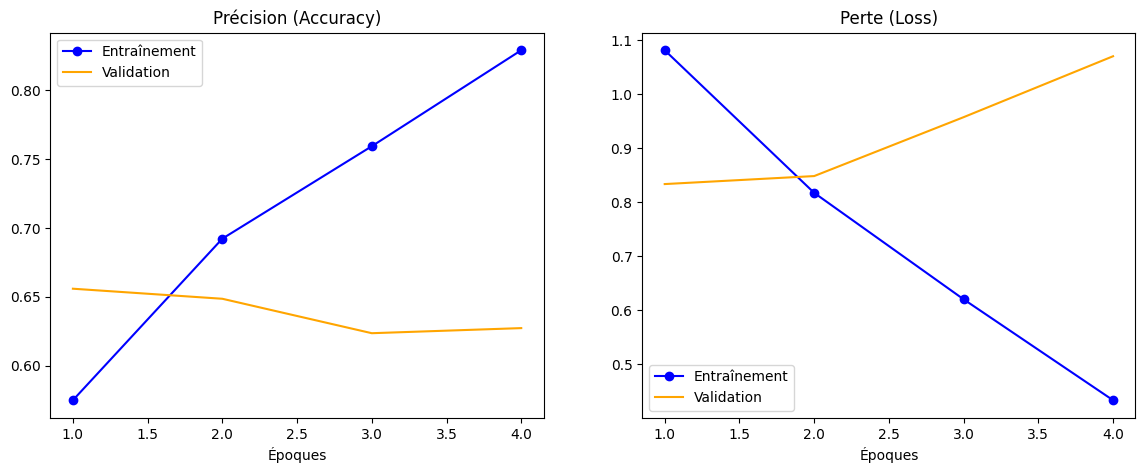

In [17]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Précision
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Entraînement')
    plt.plot(epochs, val_acc, 'orange', label='Validation')
    plt.title('Précision (Accuracy)')
    plt.xlabel('Époques')
    plt.legend()

    # Perte (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Entraînement')
    plt.plot(epochs, val_loss, 'orange', label='Validation')
    plt.title('Perte (Loss)')
    plt.xlabel('Époques')
    plt.legend()

    plt.show()

plot_learning_curves(history)

In [17]:
import seaborn as sns
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

print("\n--- Evaluation Finale MLP étoiles ---")

y_pred_probs = model_mlp.predict(X_test_tfidf, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Création de la matrice
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = [f"{star} étoile" for star in le.classes_]

# Affichage avec Seaborn
plt.figure(figsize=(9, 7))
sns.heatmap(cm_norm, 
            annot=True, 
            fmt='.2f', 
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Taux de réussite (0 à 1)'})

plt.title('Matrice de Confusion Normalisée - Prédiction des Étoiles')
plt.xlabel('Prédiction du modèle')
plt.ylabel('Valeur étoiles réels')
plt.show()

print(f"Précision (Accuracy) : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score (ajusté selon la quantité d'avis par étoile)   : {f1_tfidf :.4f}")
print(f"Perte (Log Loss)     : {loss_tfidf:.4f}")

print("\nRapport détaillé :")
print(classification_report(y_test, y_pred, target_names=class_names))


--- Evaluation Finale MLP étoiles ---


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 20000, but received input with shape (32, 10365)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 10365), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

---------
## 8. Test phrase

In [ ]:
def predict_custom_sentence(text, model, vectorizer, stars_encoder):
    # Nettoyage (exactement comme pour l'entraînement)
    text_clean = clean_text(text)
    # Vectorisation (TF-IDF)
    text_vectorized = vectorizer.transform([text_clean]).toarray()
    # Prédiction
    prediction_probs = model.predict(text_vectorized, verbose=0)
    # Décodage (Chiffre -> Mot)
    predicted_index = np.argmax(prediction_probs)
    predicted_stars = stars_encoder.inverse_transform([predicted_index])[0]
    
    print(f"Phrase : \"{text}\"")
    print(f"Prédiction des étoiles : {predicted_stars}")
    print(f"Confiance : {prediction_probs[0][predicted_index]:.2f}")
    print("-" * 40)

# ZONE DE TEST
phrases_a_tester = [
    "The food was amazing and the service was perfect!",
    "It was terrible, I will never come back.",
    "The food was okay but a bit expensive.",
    "I don't know what to think about this place." 
]

for phrase in phrases_a_tester:
    predict_custom_sentence(phrase, model_mlp, tfidf, le)

Phrase : "The food was amazing and the service was perfect!"
Prédiction : 5
Confiance : 93.64%
----------------------------------------
Phrase : "It was terrible, I will never come back."
Prédiction : 1
Confiance : 98.65%
----------------------------------------
Phrase : "The food was okay but a bit expensive."
Prédiction : 3
Confiance : 62.05%
----------------------------------------
Phrase : "I don't know what to think about this place."
Prédiction : 1
Confiance : 43.05%
----------------------------------------


### Outil	
* Deep Leanring :
Keras / TensorFlow / Scikit-Learn.	

* ia générative : 
LangChain / LlamaIndex / OpenAI API